In [5]:
from dataclasses import dataclass
import enum
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
from IPython.display import Markdown
import itertools
from matplotlib import gridspec, pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from db import Database, get_df
from common import SigmaMu, SimulateMode, SimulateParams, simulate, simulate_loop, simulate_montecarlo

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats


set_matplotlib_formats('svg')


pd.set_option('display.max_rows', None)



# Simulazione con distribuzione normale

Le strisce verticali indicano come la $\sigma_{fp}$ influisca pesantemente
nella roc_auc. Contrariamente, $\sigma_{tp}$ influenza quasi minimamente
roc_auc.

Come è ovvio che sia, il rapporto $\mu_{tp}/\mu_{fp}$ implica che la roc_auc
acquisisca valori migliori tanto più quanto quest'ultimo ha valori crescenti.

Sebbene sia ovvio che $\mu_{fp}$ e $\mu_{tp}$ possano avere un'influenza
considerevole, non lo è per quanto riguarda le varianze, soprattutto per quanto
riguarda $\sigma_{fp}$.

## ROC_AUC

Tale parametro è tanto migliore quanto più è prossimo ad uno. Nel caso si
avvicini a 0.5, indica un classificatore _inutile_, ovvero il cui esito è
equivalente al lancio di una moneta.

La curva ROC è utilizzata per capire le perfomance di un classificatore binario:
essa mostra il rapporto ottenuto tra FPR e TPR per tutti i possibili valori di
soglia, calcolati dalla funzione `roc_curve`.

In [12]:
def simualte_df(N, mus_ratios, sigma_fp_ratios, sigma_tp_ratios):
    mu_fp = 100
    dfs = []
    for mus_ratio in mus_ratios:
        for sigma_fp_ratio in sigma_fp_ratios:
            for sigma_tp_ratio in sigma_tp_ratios:
                sigmamu_fp = SigmaMu(mu_fp, mu_fp * sigma_fp_ratio)
                mu_tp = sigmamu_fp.mu * mus_ratio
                sigmamu_tp = SigmaMu(mu_tp, mu_tp * sigma_tp_ratio)
                sp = SimulateParams(sigmamu_fp, sigmamu_tp, SimulateMode.NORMAL)

                df = simulate_montecarlo(N, sp)

                df['mus_ratio'] = mus_ratio
                df['sigma_fp_ratio'] = sigma_fp_ratio
                df['sigma_tp_ratio'] = sigma_tp_ratio
                dfs.append(df)

                pass
            pass
        pass

    df = pd.concat(dfs)

    df['sigma_fp_ratio_cat'] = pd.CategoricalIndex(df['sigma_fp_ratio'])
    df['sigma_tp_ratio_cat'] = pd.CategoricalIndex(df['sigma_tp_ratio'])
    df['mus_ratio_cat'] = pd.CategoricalIndex(df['mus_ratio'])

    return df

mus_ratios = [0.5, 1.0, 3]
cats = [0.1, 0.5, 1, 3]

df_cat = simualte_df(4, mus_ratios, cats, cats)
df_lin_fp = simualte_df(4, mus_ratios, np.linspace(0.0, 4.0, 10), cats)
df_lin_tp = simualte_df(4, mus_ratios, cats, np.linspace(0.0, 4.0, 10))


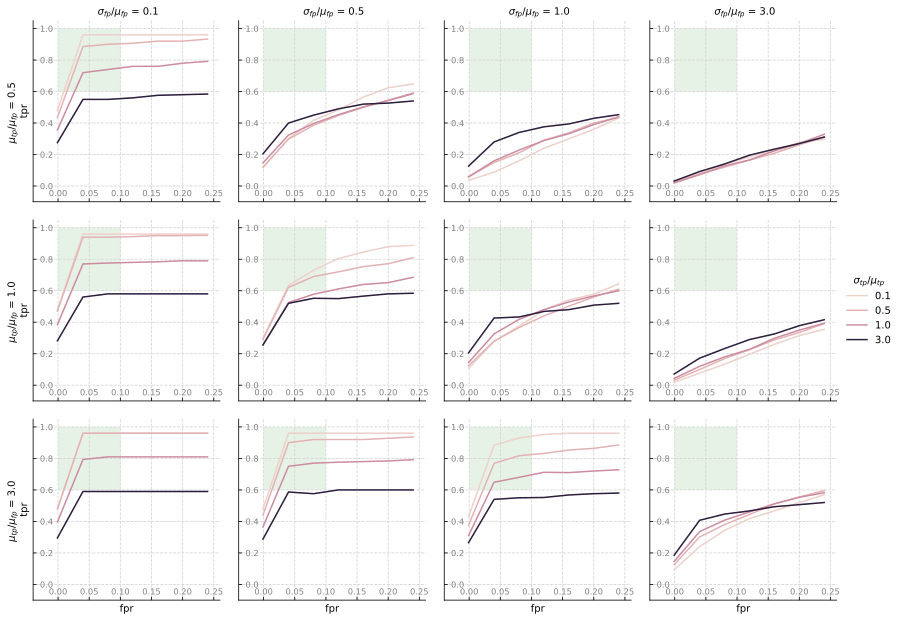

In [19]:
df = df_cat.copy()

intervals = 25

df['fpr'] = df['fpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))
df['tpr'] = df['tpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))

df = df.explode(['fpr','tpr'])

df.fpr = df.fpr.apply(lambda x: x.left)
df.tpr = df.tpr.apply(lambda x: x.left)

df = df.drop_duplicates()

df = df[df['fpr'] < 0.25]

renamer = {
    'sigma_fp_ratio': '$\\sigma_{fp}/\\mu_{fp}$',
    'sigma_fp_ratio_cat': '$\\sigma_{fp}/\\mu_{fp}\'$',
    'sigma_tp_ratio': '$\\sigma_{tp}/\\mu_{tp}$',
    'sigma_tp_ratio_cat': '$\\sigma_{tp}/\\mu_{tp}\'$',
    'mus_ratio_cat': '$\\mu_{tp}/\\mu_{fp}$'
}

g = sns.relplot(df.rename(columns=renamer), x='fpr', y='tpr', hue=renamer['sigma_tp_ratio'], col=renamer['sigma_fp_ratio'], row=renamer['mus_ratio_cat'], kind='line', markers=False, dashes=False, errorbar=('ci', 0.5), height=3, facet_kws=dict(sharey=False, sharex=False))
# sns.lmplot(df, x='fpr', y='tpr', col='sigma_tp_ratio_cat',
# row='sigma_fp_ratio_cat', hue='mus_ratio_cat', logistic=True,
# scatter_kws=dict(s=1))

rows = g.axes.shape[0]
cols = g.axes.shape[1]

[ g.axes[i,0].set_ylabel(g.axes[i,0].title.get_text().split('|')[0] + '\ntpr') for i in range(rows) ]
[ g.axes[0,j].set_title(g.axes[0,j].title.get_text().split('|')[1], size='medium') for j in range(cols) ]
[ g.axes[i,j].set_title('') for i in range(1,rows) for j in range(cols) ]
[ g.axes[i,j].grid(True, axis='both', linestyle='--', color='lightgray') for i in range(rows) for j in range(cols) ]
[ g.axes[i,j].set_yticks(list(map(lambda x: x/5, range(6)))) for i in range(rows) for j in range(cols) ]
[ g.axes[i,j].set_xticks(list(map(lambda x: x/20, range(6)))) for i in range(rows) for j in range(cols) ]
[ g.axes[i,j].tick_params(axis="x", direction="in", pad=-12, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
[ g.axes[i,j].tick_params(axis="y", direction="in", labeltop=True, pad=-20, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
[ g.axes[i,j].set_ylim(-0.1, 1.05) for i in range(rows) for j in range(cols) ]
[ g.axes[i,j].set_xlim(-0.04, 0.26) for i in range(rows) for j in range(cols) ]

from matplotlib.patches import Rectangle

rect = lambda: Rectangle((0,0.6),0.1,0.4,linewidth=0,facecolor='green',alpha=0.1,zorder=-5)

# Add the patch to the Axes
[ g.axes[i,j].add_patch(rect()) for i in range(rows) for j in range(cols) ]

plt.gcf().subplots_adjust(hspace=0.1, wspace=0.1)

plt.gcf().savefig('beamer/simulation.pdf')

/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_56372/827962689.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_th = df[th_goods + ['ths', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby([ 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']).sum().dropna()


(0.01, 0)             (0.01, 0.5)              \
sigma_fp_ratio                     0.1 0.5 1.0 3.0         0.1 0.5 1.0 3.0   
sigma_tp_ratio mus_ratio_cat                                                 
0.1            0.5                  49  12   3   3          24   0   0   0   
               1.0                  49  30  11   2          24   6   0   0   
               3.0                  49  49  44   9          24  24  19   0   
0.5            0.5                  44  12   6   2          20   0   0   0   
               1.0                  48  30  12   3          23   5   0   0   
               3.0                  49  45  38  13          24  20  14   0   
1.0            0.5                  36  15   6   2          12   0   0   0   
               1.0                  39  26  14   4          15   2   0   0   
               3.0                  40  37  32  15          16  13   7   0   
3.0            0.5                  28  20  13   3           4   0   0   0   
               1.0                  28  26  21   7           4   2   0   0   
               3.0                  30  28  27  19           6   5   3   0   

                             (0.01, 0.9)              
sigma_fp_ratio                       0.1 0.5 1.0 3.0  
sigma_tp_ratio mus_ratio_cat                          
0.1            0.5                     4   0   0   0  
               1.0                     4   0   0   0  
               3.0                     4   4   0   0  
0.5            0.5                     0   0   0   0  
               1.0                     3   0   0   0  
               3.0                     4   0   0   0  
1.0            0.5                     0   0   0   0  
               1.0                     0   0   0   0  
               3.0                     0   0   0   0  
3.0            0.5                     0   0   0   0  
               1.0                     0   0   0   0  
               3.0                     0   0   0   0

(144, 5)


144

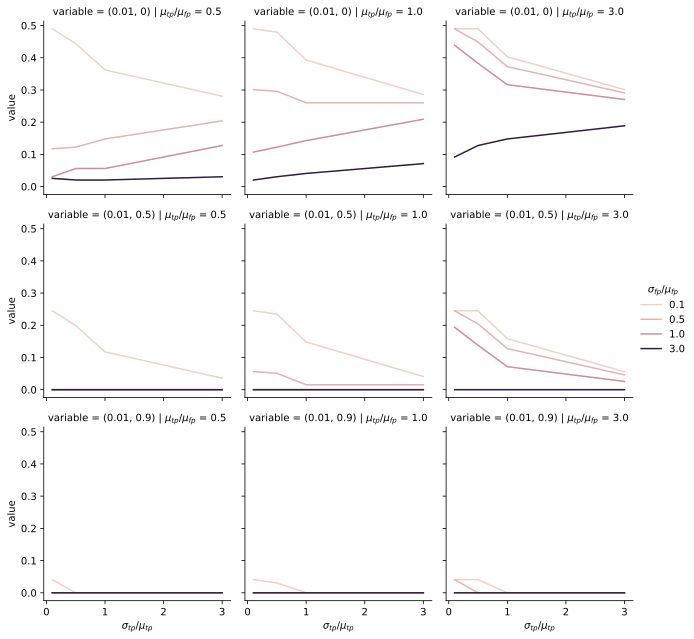

In [81]:
df = df_cat.copy()

intervals = 25

df['fpr'] = df['fpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))
df['tpr'] = df['tpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))

df = df.explode(['fpr','tpr'])

df.fpr = df.fpr.apply(lambda x: x.left)
df.tpr = df.tpr.apply(lambda x: x.left)

df = df.drop_duplicates()

th_goods = []
df['ths'] = 1
for fp_th, tp_th in itertools.product([0.01], (0, 0.5, 0.9)):
    col = f'({fp_th}, {tp_th})'
    df[col] = 1
    df[col] = df[col].where((df['fpr'] < fp_th) & (df['tpr'] > tp_th), 0)
    th_goods.append(col)
    pass



    # df['ths'] = 1
    # df['th_good'] = 1
    # df['th_good'] = df['th_good'].where((df['fpr'] < fp_th) & (df['tpr'] > tp_th), 0)


df_th = df[th_goods + ['ths', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby([ 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']).sum().dropna()

for col in th_goods:
    df_th[col] = (df_th[col] / df_th['ths'])
    pass

# ([ print(f'{col}') for col in df_th.columns])



display((df_th.drop(columns='ths').unstack().round(2) * 100).astype(int))

df_th = df_th.reset_index().melt(id_vars='sigma_tp_ratio,mus_ratio_cat,sigma_fp_ratio'.split(','), value_vars=th_goods)
print(df_th.shape)

df_th['fpr_th'] = df_th['variable'].apply(lambda x: x[1:].split(',')[0])
df_th['tpr_th'] = df_th['variable'].apply(lambda x: x[1:-1].split(',')[1])

g = sns.relplot(df_th.rename(columns=renamer),
                y='value',
                x=renamer['sigma_tp_ratio'],
                hue=renamer['sigma_fp_ratio'],
                col=renamer['mus_ratio_cat'],
                # col='tpr_th',
                row='variable',
                # style='tpar',
                # markers=True,
                # dashes=False,
                errorbar=('ci', 0.9),
                kind='line',
                height=3,
                # facet_kws=dict(sharey=False, sharex=False)
)

df_th.shape[0]